In [1]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import xarray as xr
import datetime as dt
from netCDF4 import date2num,num2date
import cftime
from math import sqrt
import matplotlib.pyplot as plt 
import sys

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, davies_bouldin_score

from MWDC import preprocessing
from MWDC import cluster_evaluations


import dask.dataframe

#### Reading .nc Data

In [2]:
path = ('./ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path, decode_times=False) 
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

## Preprocessing 

#### Transforming only sst data
- This function is used to transform the xarray dataset into a pandas dataframe where the dimension "time" would become the index of the DataFrame and, pairs of both dimensions "latitude" and "longitude" will become the columns for each variable.

In [3]:
preprocessing.null_fill(data)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float64 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float64 33.0 33.25 33.5 33.75 ... 42.5 42.75 43.0
Data variables:
    sst        (time, longitude, latitude) float64 294.0 293.8 ... 289.4 289.2
    sp         (time, longitude, latitude) float64 1.015e+05 ... 9.893e+04
    u10        (time, longitude, latitude) float64 -2.685 -2.525 ... 6.352 6.21
    v10        (time, longitude, latitude) float64 5.305 4.99 ... 11.29 10.92
    sshf       (time, longitude, latitude) float64 -4.078e+04 ... -2.794e+04
    slhf       (time, longitude, latitude) float64 -3.481e+05 ... -6.7e+05
    t2m        (time, longitude, latitude) float64 292.6 292.5 ... 288.7 288.7

In [4]:
tf_data = preprocessing.datatransformation(data)
tf_data

,"sp(43.0,-33.0)","sp(42.75,-33.0)","sp(42.5,-33.0)","sp(42.25,-33.0)","sp(42.0,-33.0)","sp(41.75,-33.0)","sp(41.5,-33.0)","sp(41.25,-33.0)","sp(41.0,-33.0)","sp(40.75,-33.0)",...,"t2m(35.25,-23.0)","t2m(35.0,-23.0)","t2m(34.75,-23.0)","t2m(34.5,-23.0)","t2m(34.25,-23.0)","t2m(34.0,-23.0)","t2m(33.75,-23.0)","t2m(33.5,-23.0)","t2m(33.25,-23.0)","t2m(33.0,-23.0)"
0.0,102443.676498,102431.303226,102417.453815,102405.135686,102391.629859,102376.995718,102354.929979,102331.617157,102306.463402,102286.930005,...,290.000848,290.122430,290.264916,290.442410,290.577520,290.716088,290.867770,291.004767,291.069088,291.095877
1.0,101345.768122,101317.220943,101287.358812,101259.804210,101229.348230,101197.229473,101161.144651,101128.482946,101095.235875,101068.601739,...,290.632579,290.666912,290.741103,290.869634,290.979348,291.094496,291.188648,291.258157,291.281510,291.312004
2.0,100624.067447,100584.979445,100543.863872,100504.640134,100464.109927,100422.816199,100374.396282,100326.188453,100276.279671,100234.684777,...,290.797767,290.884106,290.933596,290.999557,291.061465,291.153361,291.255193,291.347718,291.426658,291.535552
3.0,100114.540603,100040.682731,99966.880003,99897.586286,99832.547075,99775.380607,99718.328667,99667.461243,99619.999967,99586.044519,...,290.893986,290.875573,290.855689,290.940658,291.090622,291.246660,291.372272,291.492091,291.587344,291.698686
4.0,100697.759889,100618.637969,100538.930682,100461.853300,100384.593521,100308.381461,100226.426032,100147.134440,100068.479115,99995.435665,...,290.343238,290.741350,290.962192,291.019160,291.073186,291.165834,291.315630,291.485410,291.615917,291.696002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,98843.817016,98872.778201,98904.362934,98940.904619,98979.865525,99023.685306,99065.608941,99111.557801,99163.068418,99225.224426,...,292.431912,292.528418,292.677360,292.888889,293.059160,293.161395,293.232289,293.256524,293.238473,293.260666
361.0,98579.721408,98638.305796,98693.424812,98748.838058,98802.518619,98855.263365,98898.519207,98940.773850,98981.140520,99028.262212,...,292.397667,292.426311,292.512561,292.647280,292.745454,292.810912,292.857479,292.888796,292.889274,292.907499
362.0,98894.706481,98944.369990,98993.923163,99046.639304,99101.378273,99158.916511,99210.345398,99260.842557,99311.495004,99370.504390,...,292.438388,292.575405,292.739702,292.944218,293.099881,293.206281,293.277760,293.320371,293.326403,293.347126
363.0,98648.542535,98667.708326,98687.585171,98714.294683,98744.252980,98774.538199,98798.971517,98822.415897,98845.627345,98877.167126,...,292.060683,292.187234,292.369033,292.632800,292.846336,293.011309,293.129716,293.204905,293.263513,293.294713


In [7]:
tf_data = preprocessing.datanormalization(tf_data)


In [8]:
tf_data

,"sp(43.0,-33.0)","sp(42.75,-33.0)","sp(42.5,-33.0)","sp(42.25,-33.0)","sp(42.0,-33.0)","sp(41.75,-33.0)","sp(41.5,-33.0)","sp(41.25,-33.0)","sp(41.0,-33.0)","sp(40.75,-33.0)",...,"t2m(35.25,-23.0)","t2m(35.0,-23.0)","t2m(34.75,-23.0)","t2m(34.5,-23.0)","t2m(34.25,-23.0)","t2m(34.0,-23.0)","t2m(33.75,-23.0)","t2m(33.5,-23.0)","t2m(33.25,-23.0)","t2m(33.0,-23.0)"
0.0,0.769017,0.763551,0.758399,0.754214,0.749653,0.744597,0.739195,0.733298,0.726633,0.719377,...,0.307300,0.312956,0.318721,0.328563,0.334153,0.337154,0.340863,0.343122,0.338263,0.331969
1.0,0.550508,0.539280,0.528615,0.520168,0.510767,0.500749,0.491037,0.481886,0.472325,0.462340,...,0.366677,0.364151,0.363580,0.368759,0.371705,0.372464,0.370914,0.367119,0.358756,0.353140
2.0,0.406872,0.391876,0.377439,0.365852,0.353486,0.340685,0.327491,0.314235,0.300378,0.286403,...,0.382203,0.384572,0.381714,0.380983,0.379379,0.377956,0.377146,0.375601,0.372759,0.375038
3.0,0.305465,0.282306,0.260121,0.241803,0.223679,0.206865,0.191111,0.176584,0.162586,0.149556,...,0.391246,0.383770,0.374375,0.375442,0.382104,0.386662,0.388110,0.389274,0.388262,0.391018
4.0,0.421539,0.398652,0.376436,0.357109,0.337143,0.317032,0.296732,0.276819,0.256749,0.235928,...,0.339481,0.371150,0.384408,0.382828,0.380475,0.379120,0.382806,0.388641,0.391018,0.390756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360.0,0.052561,0.047201,0.044078,0.046307,0.048426,0.051497,0.055427,0.060420,0.066650,0.073432,...,0.535796,0.539179,0.545987,0.558745,0.566072,0.565328,0.562305,0.556372,0.547556,0.544027
361.0,0.000000,0.000000,0.001187,0.007059,0.011975,0.016685,0.020693,0.024733,0.028452,0.031877,...,0.532577,0.529579,0.530462,0.536012,0.536755,0.532624,0.527203,0.521547,0.513866,0.509431
362.0,0.062689,0.061612,0.062288,0.067914,0.073401,0.079448,0.085514,0.091616,0.097813,0.104082,...,0.536404,0.543597,0.551860,0.563950,0.569878,0.569516,0.566563,0.562419,0.556039,0.552496
363.0,0.013697,0.005919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.500904,0.507099,0.516941,0.534650,0.546183,0.551323,0.552699,0.551484,0.549971,0.547362


### t-SNE

- t-distributed Stochastic Neighbor Embedding
- It is recommended to lower the demension of data to 50 or less with `KernelPCA` before applying t-SNE.

In [9]:
kpca = KernelPCA(n_components=50, kernel='rbf', 
                 gamma=15)
X_kpca = kpca.fit_transform(tf_data)
X_kpca

array([[ 0.        ,  0.        , -0.        , ..., -0.        ,
         0.        , -0.        ],
       [ 0.00511118,  0.00811995, -0.0006996 , ..., -0.02977132,
        -0.01615265,  0.00253257],
       [ 0.00446359, -0.00784277, -0.0025156 , ...,  0.03109496,
         0.01615419, -0.00657875],
       ...,
       [-0.01125257,  0.00575143, -0.01080909, ...,  0.02065393,
        -0.05642509,  0.00504525],
       [-0.04397912,  0.0203945 ,  0.00815695, ..., -0.01812016,
         0.04765032, -0.02395567],
       [ 0.01898634, -0.00432294,  0.00374925, ..., -0.00273654,
         0.00231739, -0.00038229]])

In [10]:
X_kpca.shape

(365, 50)

- Applying t-SNE 

In [31]:
tsne = TSNE(n_components=3, learning_rate='auto', perplexity=10)
X_tsne = tsne.fit_transform(X_kpca)
X_tsne

/usr/local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


array([[ -0.45197585,  14.959303  ,  -1.6638994 ],
       [ 70.98925   ,  -9.010491  ,  13.730114  ],
       [-64.089325  ,  49.769245  ,  -0.5477502 ],
       ...,
       [-31.642931  ,   5.237061  ,  70.743034  ],
       [  8.317864  ,  -7.884194  ,  40.378902  ],
       [ 27.375473  , -51.90426   ,  -7.3529477 ]], dtype=float32)

In [32]:
distortions = []
inertias = []
K = range(1,50, 2)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X_tsne)
    distortions.append(sum(np.min(cdist(X_tsne, km.cluster_centers_,'euclidean'), axis=1)) / X_tsne.shape[0])
    inertias.append(km.inertia_)


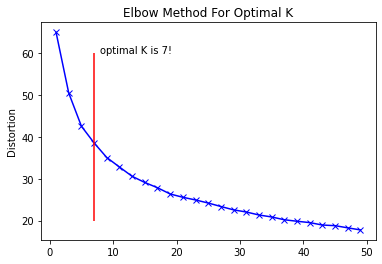

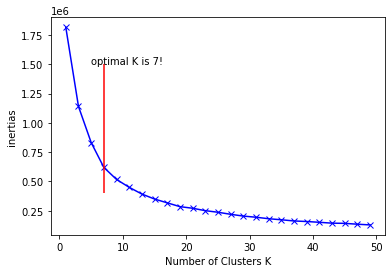

In [33]:
plt.plot(K, distortions, 'bx-')
plt.vlines(ymin=20, ymax=60, x=7, colors='red')
plt.text(x=8, y=60, s="optimal K is 7!")
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal K')
plt.show()


plt.plot(K, inertias, 'bx-')
plt.vlines(ymin=400000, ymax=1500000, x=7, colors='red')
plt.text(x=5, y=1500000, s="optimal K is 7!")
plt.xlabel('Number of Clusters K')
plt.ylabel('inertias')
plt.show()

In [37]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X_tsne)
P = kmeans.predict(X_tsne)

tf_data['Cluster'] = kmeans.labels_
labels =  kmeans.labels_
labels

array([2, 4, 0, 4, 0, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4,
       4, 1, 1, 2, 0, 0, 0, 1, 3, 3, 0, 3, 3, 0, 4, 2, 4, 2, 1, 4, 4, 2,
       2, 2, 0, 4, 4, 5, 4, 4, 2, 2, 2, 0, 0, 2, 2, 4, 2, 2, 4, 3, 5, 3,
       0, 5, 2, 5, 2, 3, 4, 5, 5, 5, 1, 4, 1, 3, 0, 2, 0, 5, 1, 0, 5, 0,
       0, 3, 3, 1, 1, 4, 1, 5, 2, 0, 1, 4, 3, 5, 3, 1, 1, 1, 5, 1, 3, 3,
       5, 3, 2, 6, 2, 4, 2, 4, 4, 3, 4, 2, 2, 5, 3, 3, 1, 1, 5, 0, 4, 4,
       0, 1, 0, 2, 0, 5, 5, 3, 3, 3, 5, 5, 0, 1, 0, 5, 5, 5, 2, 5, 5, 3,
       1, 0, 3, 0, 3, 5, 3, 3, 3, 2, 3, 0, 3, 1, 3, 2, 5, 1, 2, 1, 0, 0,
       2, 5, 3, 5, 5, 5, 0, 5, 2, 5, 3, 1, 0, 5, 0, 3, 2, 0, 0, 3, 0, 1,
       3, 2, 2, 2, 0, 0, 2, 0, 0, 5, 0, 2, 4, 4, 0, 3, 5, 0, 5, 4, 5, 0,
       5, 1, 0, 1, 0, 0, 2, 1, 2, 3, 1, 2, 2, 2, 0, 3, 0, 2, 3, 1, 2, 1,
       1, 4, 2, 3, 4, 1, 1, 1, 0, 3, 3, 4, 1, 5, 1, 5, 0, 3, 2, 5, 5, 5,
       5, 5, 5, 5, 4, 1, 4, 3, 3, 4, 4, 4, 2, 2, 5, 1, 2, 3, 3, 2, 5, 0,
       1, 5, 5, 2, 1, 1, 0, 1, 3, 3, 1, 0, 5, 3, 2,

## Evaluation

### RMSE

In [114]:

evaluation.RMSE(X_kpca,labels,tf_data,True)

,0,1,2,3,4,5,6
0,22.24,28.25,11.31,29.87,14.0,10.27,16.22
1,28.25,0.0,20.67,29.73,18.8,23.06,26.06
2,11.31,20.67,21.56,25.54,4.82,5.69,10.38
3,29.87,29.73,25.54,0.0,22.79,28.98,19.95
4,14.0,18.8,4.82,22.79,21.03,8.61,10.6
5,10.27,23.06,5.69,28.98,8.61,18.89,14.41
6,16.22,26.06,10.38,19.95,10.6,14.41,21.39


### Silhouette Coefficient score

- The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample.

- The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [41]:
print("Silhouette Coefficient score for K=7 is ", silhouette_score(X_tsne, labels))

Silhouette Coefficient score for K=7 is  0.24355634


### Davies-Bouldin score

- The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.

- The minimum score is zero, with lower values indicating better clustering.

In [39]:
print("Davies-Bouldin score for K=7 is ", davies_bouldin_score(X_tsne, labels))

Davies-Bouldin score for K=7 is  0.9225512224113819


In [ ]:
evaluation.Spat_Corr(data,labels,tf_data,True)

Long Run-time!

## Visualization

In [27]:
path_to_module = '../../MWDC/Visualization/'
sys.path.append(path_to_module)
from make_Csv_cluster import make_Csv_cluster

In [28]:
make_Csv_cluster(labels,'single_tSNE.csv')

In [29]:
sys.path.append(path_to_module)
from Visualization import visualization

total clusters:  7
varid: sst
var_range: [286.9919318332959, 299.0668423730597]


../../MWDC/Visualization/Visualization.py:129: RuntimeWarning: Mean of empty slice
  var_mean_icluster = np.nanmean(var_icluster,axis=0)
/usr/local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


AttributeError: 'QuadContourSet' object has no attribute 'ax'

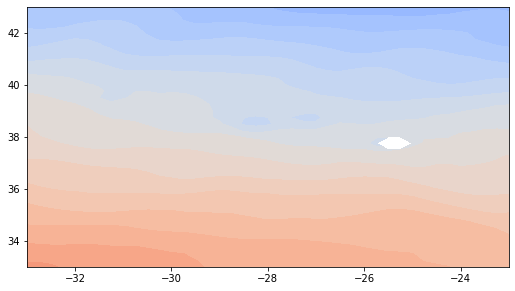

In [30]:
visualization('./ERA5_meteo_sfc_2021_daily.nc','./single_tSNE.csv','./coast.txt')
